In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
"""
https://github.com/inmcm/present_cipher/tree/master/python
"""
# coding: utf-8
from __future__ import print_function

s_box = (0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2)

inv_s_box = (0x5, 0xE, 0xF, 0x8, 0xC, 0x1, 0x2, 0xD, 0xB, 0x4, 0x6, 0x3, 0x0, 0x7, 0x9, 0xA)

p_layer_order = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51, 4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38,
                 54, 7, 23, 39, 55, 8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59, 12, 28, 44, 60, 13,
                 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63]

block_size = 64

ROUND_LIMIT = 32


def round_function(state, key):
    new_state = state ^ key
    state_nibs = []
    for x in range(0, block_size, 4):
        nib = (new_state >> x) & 0xF
        sb_nib = s_box[nib]
        state_nibs.append(sb_nib)
    # print(state_nibs)

    state_bits = []
    for y in state_nibs:
        nib_bits = [1 if t == '1'else 0 for t in format(y, '04b')[::-1]]
        state_bits += nib_bits
    # print(state_bits)
    # print(len(state_bits))

    state_p_layer = [0 for _ in range(64)]
    for p_index, std_bits in enumerate(state_bits):
        state_p_layer[p_layer_order[p_index]] = std_bits

    # print(len(state_p_layer), state_p_layer)

    round_output = 0
    for index, ind_bit in enumerate(state_p_layer):
        round_output += (ind_bit << index)

    # print(format(round_output, '#016X'))

    # print('')
    return round_output


def key_function_80(key, round_count):
    # print('Start: ', hex(key))
    # print('')

    r = [1 if t == '1'else 0 for t in format(key, '080b')[::-1]]

    # print('k bits:', r)
    # print('')

    h = r[-61:] + r[:-61]

    # print('s bits:', h)
    # print('')

    round_key_int = 0
    # print('init round int:', hex(round_key_int))
    for index, ind_bit in enumerate(h):
        round_key_int += (ind_bit << index)
        # print('round:',index, '-', hex(round_key_int))

    # print('round_key_int', hex(round_key_int))
    # print('')

    upper_nibble = round_key_int >> 76

    # print('upper_nibble:', upper_nibble)

    upper_nibble = s_box[upper_nibble]

    # print('upper_nibble sboxed', hex(upper_nibble))

    xor_portion = ((round_key_int >> 15) & 0x1F) ^ round_count
    # print('Count:', round_count)
    # print('XOR Value:', xor_portion)

    # print('Before:', hex(round_key_int))
    round_key_int = (round_key_int & 0x0FFFFFFFFFFFFFF07FFF) + (upper_nibble << 76) + (xor_portion << 15)
    # print('After: ', hex(round_key_int))

    return round_key_int



test_vectors_80 = {1:(0x00000000000000000000, 0x0000000000000000, 0x5579C1387B228445),
                2:(0xFFFFFFFFFFFFFFFFFFFF, 0x0000000000000000, 0xE72C46C0F5945049),
                3:(0x00000000000000000000, 0xFFFFFFFFFFFFFFFF, 0xA112FFC72F68417B),
                4:(0xFFFFFFFFFFFFFFFFFFFF, 0xFFFFFFFFFFFFFFFF, 0x3333DCD3213210D2)}

print('Testing 80-bit Key Vectors:')



for test_case in test_vectors_80:

    key_schedule = []
    current_round_key = test_vectors_80[test_case][0]
    round_state = test_vectors_80[test_case][1]

    # Key schedule
    for rnd_cnt in range(ROUND_LIMIT):
        # print(format(round_key, '020X'))
        # print(format(round_key >> 16, '016X'))
        key_schedule.append(current_round_key >> 16)
        current_round_key = key_function_80(current_round_key, rnd_cnt + 1)

    for rnd in range(ROUND_LIMIT - 1):
        # print('Round:', rnd)
        # print('State:', format(round_state, '016X'))
        # print('R_Key:', format(key_schedule[rnd], '016X'))
        round_state = round_function(round_state, key_schedule[rnd])

    round_state ^= key_schedule[ROUND_LIMIT-1]

    if round_state == test_vectors_80[test_case][2]:
        print('Success', hex(round_state))
    else:
        print('Failure', hex(round_state))
        
def PRESENT(P, K, ROUND):
    key_schedule = []
    current_round_key = K
    round_state = P
    
    if(ROUND==0):
        return P

    for rnd_cnt in range(ROUND):
        key_schedule.append(current_round_key >> 16)
        current_round_key = key_function_80(current_round_key, rnd_cnt + 1)

    for rnd in range(ROUND - 1):
        round_state = round_function(round_state, key_schedule[rnd])

    round_state ^= key_schedule[ROUND-1]
    
    return round_state

C = PRESENT(0x0, 0x0, ROUND=32)
print(hex(C))

Testing 80-bit Key Vectors:
Success 0x5579c1387b228445
Success 0xe72c46c0f5945049
Success 0xa112ffc72f68417b
Success 0x3333dcd3213210d2
0x5579c1387b228445


In [3]:
Wang_diff = [0x7000000000007000, 0x0700000000000700, 0x0070000000000070, 0x0007000000000007]
BLOCK_SIZE = 64

ROUND_global = 6
sample_num = 10000
test_sample_num = 10000

In [4]:
def gen(sample_num, ROUND):
    P_set = []
    K_set = []
    for i in range(sample_num):
        P_set.append(random.randrange(0,2**64))
        #print("%x" % P_set[i])
        K_set.append(random.randrange(0,2**80))
        #print("%x" % K_set[i])

    C_diff_set = []
    C_diff_label = []
    for i in range(sample_num):
        P = P_set[i]
        K = K_set[i]
        C = PRESENT(P, K, ROUND)
        for j in range(4):
            Cj = PRESENT(P^Wang_diff[j], K, ROUND)
            C_diff = C^Cj
            #print(C_diff)
            C_diff_set.append(C_diff)
            temp = [0, 0, 0, 0]
            temp[j] = 1
            C_diff_label.append(temp)

    tr_X = []
    for C_diff in C_diff_set:
        A = []
        for j in range(BLOCK_SIZE):
            A.append((C_diff>>j)&1)
        tr_X.append(A)
        #print(A)
    tr_X = np.array(tr_X)

    tr_X = []
    for C_diff in C_diff_set:
        A = []
        for j in range(BLOCK_SIZE):
            A.append((C_diff>>j)&1)
        tr_X.append(A)
        #print(A)
    tr_X = np.array(tr_X)
    tr_t = np.array(C_diff_label)

    ind = np.arange(len(tr_X))
    np.random.shuffle(ind)
    tr_X = tr_X[ind]
    tr_t = tr_t[ind]
    
    return tr_X, tr_t

In [5]:
def sample_gen():
    SAMPLE_NUM_RANGE = [10000, 50000, 100000]
    ROUND_RANGE = [3, 4, 5, 6, 7, 8]
    for sn in SAMPLE_NUM_RANGE:
        for rn in ROUND_RANGE:
            tr_X, tr_t = gen(sn, rn)
            np.save("ROUND %d SAMPLE %d Dataset" % (rn, sn), tr_X)
            np.save("ROUND %d SAMPLE %d Label" % (rn, sn), tr_t)

In [6]:
def test_sample_gen():
    TEST_SMAPLE_NUM = 10000
    for rn in ROUND_RANGE:
        te_X, te_t = gen(TEST_SMAPLE_NUM, rn)
        np.save("ROUND %d TEST_SAMPLE Dataset" % (rn), te_X)
        np.save("ROUND %d TEST_SAMPLE Label" % (rn), te_t)

In [7]:
def load_sample(SAMPLE_NUM, ROUND_NUM):
    tr_X = np.load("ROUND %d SAMPLE %d Dataset.npy" % (ROUND_NUM, SAMPLE_NUM))
    tr_t = np.load("ROUND %d SAMPLE %d Label.npy" % (ROUND_NUM, SAMPLE_NUM))
    return tr_X, tr_t

In [8]:
def load_test_sample(ROUND_NUM):
    te_X = np.load("ROUND %d TEST_SAMPLE Dataset.npy" % (ROUND_NUM))
    te_t = np.load("ROUND %d TEST_SAMPLE Label.npy" % (ROUND_NUM))
    return te_X, te_t

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


class MLP:
    def __init__(self, layer1=128, layer2=1028, layer3=None, reg=None, learning_rate=0.001):
        self.layers = self._build_layers(layer1, layer2, layer3, reg)
        self.model = tf.keras.Sequential(self.layers) 
        self.model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    def _build_layers(self, layer1, layer2, layer3, reg):
        if layer3==None:
            layers = [
                tf.keras.layers.Flatten(input_shape=(64,)),
                tf.keras.layers.Dense(layer1, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer2, activation='relu', kernel_regularizer=reg),
                #tf.keras.layers.Dense(layer3, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(4, activation='softmax')
            ]
        else:
            layers = [
                tf.keras.layers.Flatten(input_shape=(64,)),
                tf.keras.layers.Dense(layer1, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer2, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer3, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(4, activation='softmax')
            ]
        return layers

    #그냥 cross entropy를 그대로 정의함
    def _my_loss(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32) #float32 => int32로 casting #None, 1
        y_true = tf.squeeze(tf.one_hot(y_true, depth=10, dtype=tf.float32), 1) # one_hot encoding #None, 1, 10 #quezze => 1을 없애줌 => None, 10
        y_pred = tf.nn.softmax(y_pred, 1) # 한 축에 대해 softmax를 적용해라 #1 => 열을 의미 #즉, 한 행에 있는 값을 다 더하면 1이 되도록 만들어줌

        #cross entropy 그대로 적용
        #-sum t*log y 한 후에 평균 냄
        return -tf.reduce_mean(tf.reduce_sum(
                tf.multiply(y_true, tf.math.log(y_pred)), 1))

    def _my_accuracy(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.squeeze(tf.one_hot(y_true, depth=10, dtype=tf.float32), 1)
        #argmax를 그대로 이용
        return tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(y_true, 1), tf.argmax(y_pred, 1)), tf.float32))

    def fit(self, x, t, epochs, batch_size=None, validation_split=0.0, verbose=1, shuffle=False, workers=2):
        self.model.fit(x, t, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose, shuffle=shuffle, workers=workers)
    
    def evaluate(self, x=None, y=None, verbose=1):
        return self.model.evaluate(x=x, y=y, verbose=verbose)
    
    def summary(self):
        self.model.summary()

In [10]:
#Config
ROUND = 6
SAMPLE_NUM = 10000
test_sample_num = 10000
ITERATION = 5

#Fix
batch_size = 200
epoch_size = 25
validation_split = 0.3
learning_rate = 0.001

In [11]:
def learn(ROUND, SAMPLE_NUM, layer1, layer2, layer3=None, reg=None, learning_rate=0.001):
    tr_X, tr_t = load_sample(SAMPLE_NUM=SAMPLE_NUM, ROUND_NUM=ROUND)
    te_X, te_t = load_test_sample(ROUND_NUM=ROUND)
    accuracy = []
    for i in range(ITERATION):
        model = MLP(layer1, layer2, layer3, reg, learning_rate)
        model.fit(tr_X, tr_t, epochs=epoch_size, batch_size=batch_size, validation_split = validation_split, shuffle=True, verbose=0)
        accuracy.append(model.evaluate(te_X, te_t, verbose=0)[1])
    avg = np.mean(np.array(accuracy))
    #print("average : %f" % avg)
    return avg

In [12]:
def learn_reg_L2(ROUND=ROUND, l1=128, l2=512, weight=[0.0001]):
    tr_X, tr_t = gen(sample_num, ROUND)
    te_X, te_t = gen(test_sample_num, ROUND)

    result = []
    result_weight = []
    for w in weight:
        accuracy = []
        for i in range(ITERATION):
            model = MLP(layer1=l1, layer2=l2, reg=tf.keras.regularizers.L2(w))
            model.fit(tr_X, tr_t, epochs=epoch_size, batch_size=batch_size, validation_split = validation_split, verbose=0)
            accuracy.append(model.evaluate(te_X, te_t)[1])
        avg_acc = np.mean(np.array(accuracy))
        result.append(avg_acc)
        result_weight.append(w)
    return result, result_weight

In [13]:
weight = [0.0001, 0.001, 0.01, 0.1]
accuracy, accuracy_weight = learn_reg_L2(ROUND=5, l1=128, l2=512, weight=weight)
maxidx = accuracy.index(max(accuracy))
print(accuracy)
print(accuracy_weight)

1250/1250 [==============================] - 3s 2ms/step - loss: 1.3206 - accuracy: 0.3496
[0.3819149971008301, 0.41356500387191775, 0.41321499943733214, 0.3483449935913086]
[0.0001, 0.001, 0.01, 0.1]


In [14]:
weight = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
accuracy, accuracy_weight = learn_reg_L2(ROUND=5, l1=128, l2=512, weight=weight)
maxidx = accuracy.index(max(accuracy))

1250/1250 [==============================] - 4s 3ms/step - loss: 1.3228 - accuracy: 0.3522


In [15]:
RANGE1 = 100
weight2 = []
if(maxidx==0):
    base = 0
else:
    base = maxidx*0.01 - 0.005
for i in range(RANGE1):
    weight2.append(base + (i/10000.0))
print(weight2)

[0.005, 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056, 0.0057, 0.0058000000000000005, 0.0059, 0.006, 0.0061, 0.0062, 0.0063, 0.0064, 0.006500000000000001, 0.0066, 0.0067, 0.0068000000000000005, 0.0069, 0.007, 0.0071, 0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008, 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088, 0.0089, 0.009000000000000001, 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.009600000000000001, 0.0097, 0.0098, 0.009899999999999999, 0.01, 0.010100000000000001, 0.0102, 0.0103, 0.0104, 0.010499999999999999, 0.0106, 0.010700000000000001, 0.0108, 0.0109, 0.011, 0.0111, 0.0112, 0.011300000000000001, 0.0114, 0.0115, 0.0116, 0.0117, 0.0118, 0.0119, 0.012, 0.0121, 0.012199999999999999, 0.0123, 0.012400000000000001, 0.0125, 0.0126, 0.0127, 0.012799999999999999, 0.012900000000000002, 0.013000000000000001, 0.0131, 0.0132, 0.0133, 0.013399999999999999, 0.013500000000000002, 0.013600000000000001, 0.0137, 0.0138, 0.0139, 0.013999999999999999, 0.014100000

In [16]:
accuracy, accuracy_weight = learn_reg_L2(5, 128, 512, weight2)

1250/1250 [==============================] - 5s 4ms/step - loss: 1.2453 - accuracy: 0.4179


1250/1250 [==============================] - 5s 4ms/step - loss: 1.2395 - accuracy: 0.4177


1250/1250 [==============================] - 1s 905us/step - loss: 1.2508 - accuracy: 0.4077


1250/1250 [==============================] - 1s 891us/step - loss: 1.2537 - accuracy: 0.4097


1250/1250 [==============================] - 1s 968us/step - loss: 1.2557 - accuracy: 0.4093


1250/1250 [==============================] - 1s 951us/step - loss: 1.2599 - accuracy: 0.4032


In [17]:
maxidx1 = accuracy.index(max(accuracy))
print("max weight idx : %d" % maxidx1)
print("max weight : %f" % accuracy_weight[maxidx1])
print("max accuracy : %f" % accuracy[maxidx1])

max weight idx : 16
max weight : 0.006600
max accuracy : 0.420540


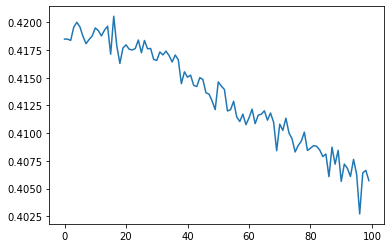

In [18]:
plt.plot([i for i in range(RANGE1)], accuracy)

In [19]:
unit = 1/10000.0
start = accuracy_weight[maxidx1] + (-1)*unit
end = accuracy_weight[maxidx1] + (+1)*unit
step_num = 100
step = unit/step_num
weight2 = np.arange(start, end, step)
print(accuracy_weight[maxidx1])
print(weight2)

0.0066
[0.0065   0.006501 0.006502 0.006503 0.006504 0.006505 0.006506 0.006507
 0.006508 0.006509 0.00651  0.006511 0.006512 0.006513 0.006514 0.006515
 0.006516 0.006517 0.006518 0.006519 0.00652  0.006521 0.006522 0.006523
 0.006524 0.006525 0.006526 0.006527 0.006528 0.006529 0.00653  0.006531
 0.006532 0.006533 0.006534 0.006535 0.006536 0.006537 0.006538 0.006539
 0.00654  0.006541 0.006542 0.006543 0.006544 0.006545 0.006546 0.006547
 0.006548 0.006549 0.00655  0.006551 0.006552 0.006553 0.006554 0.006555
 0.006556 0.006557 0.006558 0.006559 0.00656  0.006561 0.006562 0.006563
 0.006564 0.006565 0.006566 0.006567 0.006568 0.006569 0.00657  0.006571
 0.006572 0.006573 0.006574 0.006575 0.006576 0.006577 0.006578 0.006579
 0.00658  0.006581 0.006582 0.006583 0.006584 0.006585 0.006586 0.006587
 0.006588 0.006589 0.00659  0.006591 0.006592 0.006593 0.006594 0.006595
 0.006596 0.006597 0.006598 0.006599 0.0066   0.006601 0.006602 0.006603
 0.006604 0.006605 0.006606 0.006607 0.00660

In [20]:
accuracy, accuracy_weight = learn_reg_L2(5, 128, 512, weight2)

1250/1250 [==============================] - 1s 949us/step - loss: 1.2423 - accuracy: 0.4125


1250/1250 [==============================] - 1s 946us/step - loss: 1.2474 - accuracy: 0.4115


1250/1250 [==============================] - 1s 994us/step - loss: 1.2447 - accuracy: 0.4123


1250/1250 [==============================] - 1s 978us/step - loss: 1.2385 - accuracy: 0.4166


1250/1250 [==============================] - 1s 975us/step - loss: 1.2419 - accuracy: 0.4152


1250/1250 [==============================] - 1s 986us/step - loss: 1.2414 - accuracy: 0.4159


1250/1250 [==============================] - 1s 1ms/step - loss: 1.2408 - accuracy: 0.4160


1250/1250 [==============================] - 1s 1ms/step - loss: 1.2428 - accuracy: 0.4125


1250/1250 [==============================] - 1s 1ms/step - loss: 1.2482 - accuracy: 0.4094


1250/1250 [==============================] - 1s 984us/step - loss: 1.2428 - accuracy: 0.4141


KeyboardInterrupt: 

In [21]:
maxidx1 = accuracy.index(max(accuracy))
print("max weight idx : %d" % maxidx1)
print("max weight : %f" % accuracy_weight[maxidx1])
print("max accuracy : %f" % accuracy[maxidx1])

max weight idx : 16
max weight : 0.006600
max accuracy : 0.420540


ValueError: x and y must have same first dimension, but have shapes (201,) and (100,)

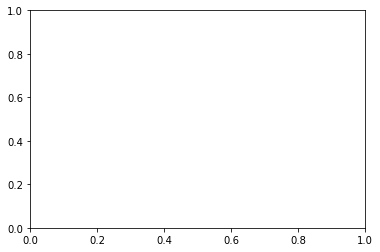

In [22]:
plt.plot([i for i in range(step_num*2+1)], accuracy)